In [1]:
#install google-scraper dikarenakan Playstore Tidak ada API.
!pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00


In [2]:
pip install wordCloud

In [3]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.7 MB/s eta 0:00:00


In [4]:
#import Library
import pandas as pd
import numpy as np
import re #digunakan dalam python untuk regular expresion untuk mencari pola yang berfungsi untuk mencocokan
#menumukan, memanipulasi teks
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud #untuk membuat wordcloud
from google_play_scraper import reviews
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [5]:
#scraping ulasan aplikasi livin
result, _ = reviews(
    'id.bmri.livin', # ID aplikasi Livin di Google Play
    lang='id',
    country='id',
    count=5000 #mengambil 1000 ulasan
)

In [6]:
#Konversi ke DataFrame
df = pd.DataFrame(result)[['content']]
df.rename(columns={'content':'ulasan'}, inplace=True)

In [7]:
#Tampilkan Data
df.head()

,ulasan
0,sangat membantu
1,sering matikan hp dulu.kemudiandihidupkan .bar...
2,sangat bagus dan membantu sekali
3,sangat puas dengan aplikasi ini
4,sangat membantu


In [8]:
#Preprocessing Data
stemmer = StemmerFactory().create_stemmer()

In [9]:
#kamus kata slang dan typo
slang_dict = {"bgt":"banget",
              "gpp": "tidak apa-apa",
              "bagusss": "bagus",
              "jd": "jadi",
              "kmu":"kamu",
              "aq":"aku",
              "gw": "saya",
              "loe": "kamu",
              "baper": "terbawa perasaan",
              "mager": "malas gerak",
              "gabut": "tidak ada kerjaan",
              "santuy": "santai",
              "gaje": "tidak jelas",
              "woles": "tenang",
              "otw": "sedang dalam perjalanan",
              "btw": "ngomong-ngomong",
              "kuy": "ayo",
              "gan": "juragan",
              "sis": "kakak perempuan",
              "sist": "kakak perempuan",
              "bro": "saudara laki-laki",
              "cmiiw": "koreksi jika saya salah",
              "asap": "secepat mungkin",
              "japri": "jalur pribadi",
              "mantul": "mantap betul",
              "rekber": "rekening bersama",
              "bocil": "bocah kecil",
              "vibes": "suasana",
              "spill": "membocorkan",
              "ghosting": "menghilang tanpa kabar",
              "flexing": "pamer",
              "cringe": "memalukan",
              "ngegas": "marah",
              "nolep": "tidak memiliki kehidupan sosial",
              "halu": "halusinasi",
              "wkwk": "tertawa",
              "lol": "tertawa terbahak-bahak",
              "brb": "akan segera kembali",
              "gk" : "tidak",
              "ga" : "tidak",
              "tdk" : "tidak",
              "mager": "malas gerak",
              "gabut": "tidak ada kerjaan",
              "santuy": "santai",
              "mrh": "marah",
              "gpp": "tidak apa-apa",
              "murahhh":"murah",

              # Typo
              "akn": "akan",
              "bnr": "benar",
              "kmn": "kemana",
              "gmna": "bagaimana",
              "mkn": "makan",
              "mnum": "minum",
              "klr": "keluar",
              "bljr": "belajar",
              "tdk": "tidak",
              "bgt": "banget",
              "dngn": "dengan",
              "sya": "saya",
              "trs": "terus",
              "bsa": "bisa",
              "skrg": "sekarang",
              "bkn": "bukan",
              "udh": "sudah",
              "sdh": "sudah",
              "trmks": "terima kasih",
              "smg": "semoga",
              "bbrp": "beberapa",
              "tp": "tapi",
              "krn": "karena",
              "td": "tadi",
              "pgn": "ingin",
              "nyebelin": "menyebalkan",
              "knp": "kenapa",
              "jd": "jadi",
              "dpt": "dapat",
              "mnrt": "menurut",
              "gk": "tidak",
              "ga": "tidak",
              "jg": "juga",
              "trs": "terus",
              "dlm": "dalam",
              "tp": "tapi",
              "smua": "semua",
              "trsbh": "tersebut",
              "ajh": "aja",
              "sj": "saja",
              "kl": "kalau",
              "trus": "terus",
              "dr": "dari"
                        }

In [10]:
#Clean teks
def clean_text(text):
  text = text.lower() #Lowercasing
  text = re.sub(r'\d+', '', text)  # Hapus angka)
  text = text.translate (str.maketrans('','', string.punctuation)) #hapus tanda baca
  text = ' '.join([slang_dict[word] if word in slang_dict else word for word in text.split()])#Normalisasi
  text = stemmer.stem(text) # Stemming
  return text

In [11]:
df['clean_ulasan'] = df['ulasan'].apply(clean_text)

In [12]:
df.head()

,ulasan,clean_ulasan
0,sangat membantu,sangat bantu
1,sering matikan hp dulu.kemudiandihidupkan .bar...,sering mati hp dulukemudiandihidupkan baru bis...
2,sangat bagus dan membantu sekali,sangat bagus dan bantu sekali
3,sangat puas dengan aplikasi ini,sangat puas dengan aplikasi ini
4,sangat membantu,sangat bantu


In [13]:
#Labeling Sentimen Berdasarkan Kata-kata Positif,Netral dan Negatif
positive_words = ["bagus", "mantap", "cepat", "puas", "senang", "baik", "suka","gampang","mudah",
                  "lebih mudah","serba mudah","keren","menarik","membantu","praktis","top","terbaik","bantu","puas","memuaskan","manfaat",
                  "cocok",]
netral_words = ["aku","saya","kemarin","pas","debit","kredit","atm","bank","mandiri","sinyal"]
negative_words = ["buruk", "lama", "error", "tidak", "jelek", "lelet", "kecewa","penipuan","blokir","eror","kurang","berat","bego","lambat","susah","masalah","banget"]

In [14]:
#membuat fungsi untuk labeling dengan Lexicon based
def sentimen_label(text):
  # sum (1 for word in text.split() if word in ..... --> code ini menjelaskan untuk split kata perkata lalu di hitung jumlah kata selama kata kata itu postif,negatif dan netral)
  pos_count = sum(1 for word in text.split() if word in positive_words)
  netral_count = sum(1 for word in text.split() if word in netral_words)
  neg_count = sum(1 for word in text.split() if word in negative_words)
  # membuat if else jika kata postif bernilai lebih besar dari kata negatif maka labeling 'positif' begitu juga dengan negatif dan netral
  if pos_count > neg_count:
    return 'positif'
  elif pos_count < neg_count:
    return 'negatif'
  else :
    return 'netral'

In [16]:
#implementasi pada feature dengan menggunakan fungsi labeling
df ['sentimen'] = df['clean_ulasan'].apply (sentimen_label)

In [17]:
#melihat data sebanyak 19 data
df.head(20)

,ulasan,clean_ulasan,sentimen
0,sangat membantu,sangat bantu,positif
1,sering matikan hp dulu.kemudiandihidupkan .bar...,sering mati hp dulukemudiandihidupkan baru bis...,netral
2,sangat bagus dan membantu sekali,sangat bagus dan bantu sekali,positif
3,sangat puas dengan aplikasi ini,sangat puas dengan aplikasi ini,positif
4,sangat membantu,sangat bantu,positif
5,Sangat bagus tolong dung akhir2 ini apk sering...,sangat bagus tolong dung akhir ini apk sering ...,positif
6,sangat baik,sangat baik,positif
7,Ok,ok,netral
8,Kenapa yaa klo mau transfer daftar nama si pen...,kenapa yaa klo mau transfer daftar nama si ter...,netral
9,ok,ok,netral


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ulasan        5000 non-null   object
 1   clean_ulasan  5000 non-null   object
 2   sentimen      5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [20]:
#mengihung jumlah kata sentimen negatif,netral dan positif
df['sentimen'].value_counts()

,count
sentimen,
negatif,1882
netral,1807
positif,1311


  Sentimen  Frekuensi  Persentase
0  negatif       1882       37.64
1   netral       1807       36.14
2  positif       1311       26.22


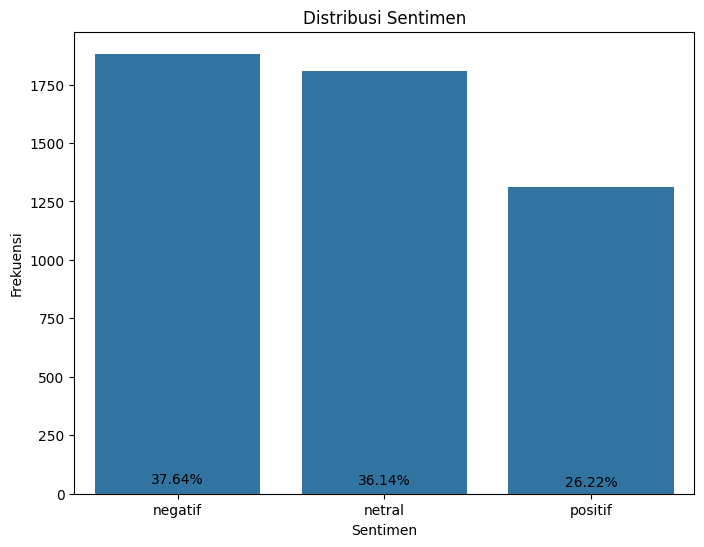

In [22]:
#membuat visualisasi pada sentimen
sentimen_counts = df['sentimen'].value_counts()
sentimen_percentage = sentimen_counts / len(df) * 100
sentimen_df = pd.DataFrame({'Sentimen': sentimen_counts.index, 'Frekuensi': sentimen_counts.values, 'Persentase': sentimen_percentage.values})
print(sentimen_df)

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentimen', y='Frekuensi', data=sentimen_df)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Frekuensi')

for i, v in enumerate(sentimen_percentage.values):
    plt.text(i, v + 5, f'{v:.2f}%', ha='center')

plt.show()

In [23]:
#melihat data ke 500 sampai akhir
df.iloc[500:]

,ulasan,clean_ulasan,sentimen
500,tampilannya bagus,tampil bagus,positif
501,Aplikasi nya sangat membantu...canggih semua n...,aplikasi nya sangat membantucanggih semua nya ...,netral
502,Sangat membantu dan mudah digunakan,sangat bantu dan mudah guna,positif
503,Alhamdulillah mempermudah saat Jauh Dari pusat...,alhamdulillah mudah saat jauh dari pusat ramai,positif
504,lancar tdk ada kendala,lancar tidak ada kendala,negatif
...,...,...,...
4995,"livin tidak bisa di pakai, aplikasi ga guna",livin tidak bisa di pakai aplikasi tidak guna,negatif
4996,𝙺𝚎𝚗𝚊𝚙𝚊 𝚝𝚒𝚍𝚊𝚔 𝚋𝚒𝚜𝚊 𝚖𝚊𝚜𝚞𝚔 𝚕𝚒𝚟𝚒𝚗 𝚗𝚢𝚊 𝚔𝚎 𝙷𝙿 𝚋𝚊𝚛𝚞 𝚙...,,netral
4997,Suport♥️👍,suport,netral
4998,Kenapa livin sering ngelag ya klo mau buka apl...,kenapa livin sering ngelag ya klo mau buka apl...,netral


In [24]:
#konversi teks ke vektor (Tokenisasi & Padding)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_ulasan'])
X = tokenizer.texts_to_sequences(df['clean_ulasan'])
X = pad_sequences(X, maxlen=50) #Padding Sequences

In [25]:
# label dimasukkan ke list dan dimapping dengan loop
list_label =[]
for label in df['sentimen']:
    if label == 'positif':
        list_label.append(0)
    elif label == 'netral':
        list_label.append(1)
    else:
         list_label.append(2)


In [26]:
#konversi label ke numerik
y=np.array(list_label)

In [27]:
#Split Data Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#Melatih Model LSTM
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=50),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32,activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
# input_dim=len(tokenizer.word_index)+1 --> jumlah kata unik(vocabulary size) dalam tokenizer +1
#output_dim=128 --> setiap kata dikonversi menjadi vektor berdimensi 128
#input_length=50 --> Panjang maksimal dari setiap input teks(padding akan digunakan jika lebih pendek).

#fungsi LSTM pertama dengan 128 unit(neuron) pada layer utama untuk Sequence
#return_sequences = True --> mengembalikan urutan lengkap dari setiap langkah waktu agar bisa digunakna oleh LSTM berikutnya

#Dropout(0.3) --> fungsi : untuk mengurangi overfitting dengan  membuang 30% neuron selama training.
                  #tujuan : Mencegah Model terlalu bergantung pada pola tertentu dalam data.

#LSTM kedua (Layer Akhir untuk Representasi)
#LSTM(64) --> Fungsi : LSTM kedua dengan 64 unit, tanpa return_sequences karena ini adalah layer terakhir LSTM
              #perbedaan dengan LSTM pertama : Hanya Mengembalikan keluaran terakhir.
              #Tujuan: menangkap fitur penting dari ouput LSTM pertama untuk dikirimkan ke layer Dense.

#Dense layer (Fully Connected)
#Dense(32,activation='relu') - Fungsi : layer Fully Connected dengan 32 neuron.
                            # - Aktivasi : relu --> untuk mengangkap fitur non linear dari data.
                            # - Tujuan : Memproses Informasi dari LSTM untuk di persiapkan ke output akhir.
#Output layer (Prediksi Sentimen)
# Dense(3, activation='softmax') - 3 : Jumlah neuron,sesuai dengan jumlah kelas sentimen(positif,netral dan negatif)
                                 # - activation='softmax': fungsi aktivasi softmax untuk menghasilkan probabilitas untuk setiap kelas.
                                 #Kelas dengan probabilitas tertinggi akan menjadi prediksi model.




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Kesimpulan:


*  Model ini mengambil teks, mengonversinya menjadi embedding vektor, lalu menggunakan dua LSTM layer untuk menangkap informasi sekuensial.
*   Dropout digunakan untuk regularisasi agar menghindari overfitting.


*   Output sigmoid digunakan untuk klasifikasi biner.






In [29]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

#metode .compile() digunakan untuk mengonfigurasi model sebelum pelatihan.
# Tiga parameter utama yang digunakan:
#loss --> Fungsi kerugian (Loss Function)
#optimizer --> Algoritma optimasi
# Metrics --> Metode evaluasi kinerja model

# sparse_categorical_crosssentropy --> digunakan karena memiliki 3 label
# rumus : Loss = -Σ(y_true_i * log(y_pred_i))

#optimizer ='adam' --> untuk algoritma optimasi.

#metrics=['accuracy'] --> adalah metrik yang umum digunakan untuk mengevaluasi kinerja model klasifikasi
#rumus : Accuracy = (Jumlah prediksi yang benar) / (total jumlah prediksi)

In [30]:
# Training Model
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test))

#epochs = 5 : jumlah epoch yang akan dijalankan selama pelatihan.satu epoch berarti model telah melihat seluruh data pelatihan sekali
#batch_size = 16 : Ukuran batch yang digunakan selam pelatihan. Batch size menentukan jumlah sampel data yang diproses sebelum bobot model diperbaharui.
#validation_data = (X_test, y_test) : Data validasi yang digunakan untuk memantau kinerja model selama pelatihan. Data validasi membantu untuk mendeteksi overfitting dan memilih model terbaik

#cara kerja :
#1.Inisialisasi : Model diinsiasi dengan bobot acak.
#2.iterasi Epoch : Proses pelatihan diulang sebanyak epoch yang di tentukan.
#3.Iterasi Batch : Dalam setiap epoch, data pelatiahn dibagi menjadi batch-batch.
#4.Forward Pass: Model memproses setiap batch data dan menghasilkan prediksi.
#5.Hitung Loss : fungsi kerugian dihitung dnegan membandingkan prediksi model dengan label target kerugian.
#6.Backward Pass : Gradien dihitung untuk setiap bobot model menggunakan backprogation. Gradien menunjukkan arah dn besarnya perubahan bobot yang diperlukan untuk meminimalkan funngsi kerugian.
#7.Perbarui Bobot : Optimizer memperbaharui bobot model berdasarkan gradien yang dihitung.
#8.Evaluasi:Setelah setiap Epoch, model dievaluasi menggunakan data validasi untuk memantau kinjerjanya.
#9.Penyipanan History : Informasi tentang proses pelatihan, seperti loss dan metrik, disimpan dalam objek history.


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.5570 - loss: 0.8767 - val_accuracy: 0.9070 - val_loss: 0.2349
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - accuracy: 0.9377 - loss: 0.1668 - val_accuracy: 0.9700 - val_loss: 0.0834
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9737 - loss: 0.0801 - val_accuracy: 0.9820 - val_loss: 0.0696
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.9888 - loss: 0.0418 - val_accuracy: 0.9750 - val_loss: 0.0689
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9884 - loss: 0.0413 - val_accuracy: 0.9840 - val_loss: 0.0391


In [31]:
# Evaluasi Model
y_pred_probs = model.predict(X_test)  # Prediksi probabilitas untuk setiap kelas
y_pred = np.argmax(y_pred_probs, axis=-1)  # Mendapatkan prediksi kelas (indeks kelas dengan probabilitas tertinggi)
print(classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       282
           1       0.97      0.98      0.98       369
           2       0.99      0.99      0.99       349

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



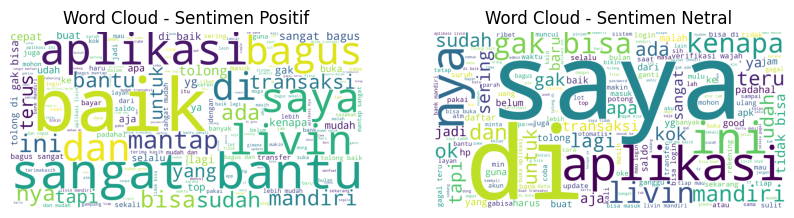

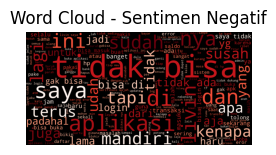

In [32]:
#  Visualisasi Word Cloud (Positif & Negatif)
pos_text = ' '.join(df[df['sentimen'] == 'positif']['clean_ulasan'])
net_text = ' '.join(df[df['sentimen'] == 'netral']['clean_ulasan'])
neg_text = ' '.join(df[df['sentimen'] == 'negatif']['clean_ulasan'])

wordcloud_pos = WordCloud(width=2000, height=1000, background_color='white').generate(pos_text)
wordcloud_net = WordCloud(width=2000, height=1000, background_color='white').generate(net_text)
wordcloud_neg = WordCloud(width=2000, height=1000, background_color='black', colormap='Reds').generate(neg_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.title("Word Cloud - Sentimen Positif")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_net)
plt.axis("off")
plt.title("Word Cloud - Sentimen Netral")
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.title("Word Cloud - Sentimen Negatif")
plt.show()
